# Signal classification: simple neural network

This is a toy model for the gravitational-wave data analysis task. Here I will consider three types of signals (double-horn shape, line, noise) and apply neural network algorithm to classify them. The aim of that analysis is to distinguish a signal with the astrophysical origin (double-horn shape) from the environmental, Earth-based, disturbance (line) and a white noise that is always present in the detector.

Astrophysical motivation and possible ranges of parameters are described in [Leaci et al. (2016)](https://arxiv.org/pdf/1607.08751.pdf).

# 1. *Pure signal*

## Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.gridspec as gridspec
import random
import math
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.utils import plot_model

## Labels
I declare labels for three types of signals: 0 - double horn, 1 - line, 2 - Gaussian noise.

In [2]:
labels = [0, 1, 2]

## Generate input data

### Double-horn shape
This signal is built with the two Gaussian functions, concatenated in the minimum.

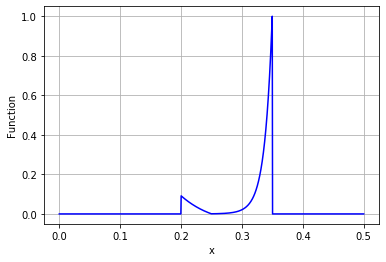

In [3]:
# Frequency range [Hz]
f_min = 0.0 
f_max = 0.5 
f = np.linspace(f_min, f_max, num = 1000, endpoint = True)
    
# Double horn shape parameters
peak1 = 0.2 
peak2 = 0.35 
minimum = 0.25  
      
# Gaussian parameters; values of parameters u, z, q, g have physical motivations
sig = 0.1
mu = 0.0 
u = 2.0
z = 2.0
q = 1.7
g = 1.0

# Calculate signal
def calc_2Gauss(f, f_min, f_max, peak1, peak2, minimum, sig, mu, u, z, q, g):
# Calculate 2nd Gauss
    f2 = np.asarray(list(filter(lambda x: x >= minimum and x <= peak2, f)))
    power2 = ((f2 - mu)**q)/(g * sig**2)
    G2 = np.exp(power2)

# This is needed to stitch functions in their extremum
    G2_min = min(G2)  

# This is a scaling factor, so both horns have a similar high
    G2_max = max(G2) 

# Calculate 1st Gauss
    f1 = np.asarray(list(filter(lambda x: x >= peak1 and x < minimum, f)))
    power1 = -((f1 - mu)**z)/(u*sig**2)
    G0 = G2_max * np.exp(power1)
    G0_min = min(G0)
    scaling_factor = G2_min - G0_min
    G1 = G0 + scaling_factor

# Fill rest f range with 0 in y
    f01 = np.asarray(list(filter(lambda x: x < peak1, f)))
    G01 = np.zeros(len(f01))
    f02 = np.asarray(list(filter(lambda x: x > peak2, f)))
    G02 = np.zeros(len(f02))

# Concatenate arguments  
    freq = np.concatenate((f01, f1, f2, f02), axis=0)
    Gauss = np.concatenate((G01, G1, G2, G02), axis=0)

# Let us normalise function so it takes values from 0 to 1
    Gauss = Gauss/max(Gauss)
    return freq, Gauss

freq, signal1 = calc_2Gauss(f, f_min, f_max, peak1, peak2, minimum, sig, mu, u, z, q, g)

# Plot
fig0 = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])    
ax0.set_ylabel(r'Function')	
ax0.set_xlabel(r'x')
ax0.grid(True)
ax0.plot(freq, signal1, color='blue', linestyle = '-')	 

Now we know how the signal looks like. We need to generate many of such signals for the various parameters.

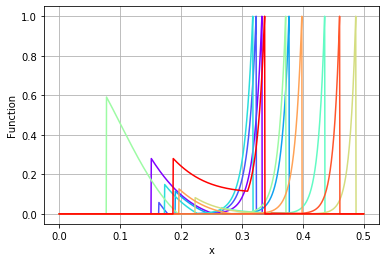

In [4]:
arr_signal1 = []
color = iter(cm.rainbow(np.linspace(0, 1, 10)))
fig1 = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0])    
ax1.set_ylabel(r'Function')	
ax1.set_xlabel(r'x')
ax1.grid(True)
for i in range(0, 10):
    peak1 = random.uniform(f_min + 0.05, 0.4)
    for j in range(0, 10):
        peak2 = random.uniform(peak1 + 0.1, f_max - 0.01)
        for k in range(0,100):
            minimum = random.uniform(peak1 + 0.01, peak2 - 0.01)
            freq, signal1 = calc_2Gauss(f, f_min, f_max, peak1, peak2, minimum, sig, mu, u, z, q, g)
            arr_signal1.append(signal1)
    c = next(color)
    ax1.plot(freq, signal1, color=c, linestyle = '-')
arr_signal1 = np.asarray(arr_signal1)
# First column is dedicated for the label
extra_col = np.zeros((arr_signal1.shape[0], 1))
extra_col.fill(0)
arr_signal1 = np.hstack((extra_col, arr_signal1))
            

### Line
The environmental disturbance is (approximately) represented as a Dirac delta function.

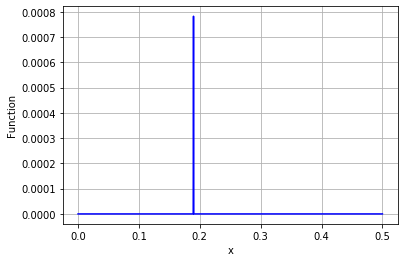

In [5]:
random_f_idx = random.randint(0, len(f))
signal2 = np.zeros(len(f))
amp = random.random()
signal2[random_f_idx] = amp
fig2 = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax2 = plt.subplot(gs[0])    
ax2.set_ylabel(r'Function')	
ax2.set_xlabel(r'x')
ax2.grid(True)
ax2.plot(freq, signal2, color='blue', linestyle = '-')

Again, we will need many of possible line-like signals. We randomise their amplitude and x at which they occur.

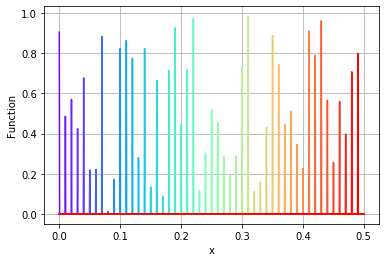

In [6]:
arr_signal2 = []
color = iter(cm.rainbow(np.linspace(0, 1, 50)))
fig3 = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax3 = plt.subplot(gs[0])    
ax3.set_ylabel(r'Function')	
ax3.set_xlabel(r'x')
ax3.grid(True)
for i in range(len(f)):
    for j in range(0, 10):
        line = np.zeros(len(f))
        amp = random.random()
        line[i] = amp
        arr_signal2.append(line)
    if i%20 == 0:
        c = next(color)
        ax3.plot(freq, line, color=c, linestyle = '-')
arr_signal2 = np.asarray(arr_signal2)
# First column is dedicated for the label
extra_col = np.zeros((arr_signal2.shape[0], 1))
extra_col.fill(1)
arr_signal2 = np.hstack((extra_col, arr_signal2))
    

### Noise
Last type of our observable is a Gaussian noise.


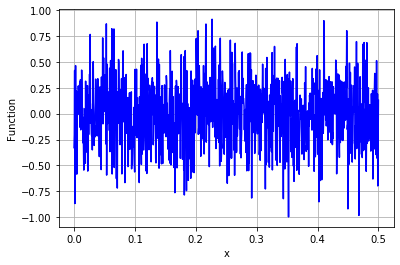

In [7]:
fig4 = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax4 = plt.subplot(gs[0])    
ax4.set_ylabel(r'Function')	
ax4.set_xlabel(r'x')
ax4.grid(True)

noise = np.random.normal(0, 1, len(f))
noise = noise/max(abs(noise))
ax4.plot(freq, noise, color='blue', linestyle = '-')

And again, we generate (10 times len(f)) random realisations of the third type of the signal.

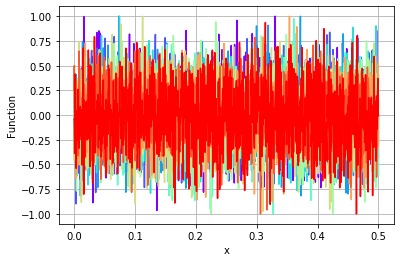

In [8]:
arr_signal3 = []
color = iter(cm.rainbow(np.linspace(0, 1, 10)))
fig5 = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax5 = plt.subplot(gs[0])    
ax5.set_ylabel(r'Function')	
ax5.set_xlabel(r'x')
ax5.grid(True)
for i in range(10 * len(f)):
    noise = np.random.normal(0, 1, len(f))
# Normalise
    noise = noise/max(abs(noise))
    arr_signal3.append(noise)
    if i%1000 == 0:
        c = next(color)
        ax5.plot(freq, noise, color=c, linestyle = '-')
arr_signal3 = np.asarray(arr_signal3)
# First column is dedicated for the label
extra_col = np.zeros((arr_signal3.shape[0], 1))
extra_col.fill(2)
arr_signal3 = np.hstack((extra_col, arr_signal3))

Finally we have three arrays with three types of signals. All arrays have the same shape. We can concatenate all of them together.

In [9]:
print(arr_signal1.shape)
print(arr_signal2.shape)
print(arr_signal3.shape)
arr_in = np.concatenate((arr_signal1, arr_signal2, arr_signal3), axis=0)
print(arr_in.shape)

(10000, 1001)
(10000, 1001)
(10000, 1001)
(30000, 1001)


## Train and test data
Let us split our input arrayto the train data (80% of the dataset) and test data (20%). First we need to shuffle rows in the input column.

In [10]:
# Shuffle rows of the array with the data
random.shuffle(arr_in)

# The first column contains the target labels
p = int(0.8*arr_in.shape[0])
X_train = arr_in[:p, 1:]
y_train = arr_in[:p, 0]
X_test = arr_in[p:, 1:]
y_test = arr_in[p:, 0]
N = X_train.shape[0]
D = X_train.shape[1]
print(N,D)

24000 1000


## Build a simple neural network model
Now we can build a very simple NN model. This is 'Just your regular densely-connected NN layer' (see [tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) ). I empirically checked several numbers of filters in layers, as well as numers of epochs in model training. I chose minimal values that give satisfying results.

Epoch 1/10
750/750 [==============================] - 2s 2ms/step - loss: 1.5859 - accuracy: 0.9918
Epoch 2/10
750/750 [==============================] - 1s 2ms/step - loss: 1.1225 - accuracy: 0.9989
Epoch 3/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2327 - accuracy: 0.9997
Epoch 4/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/10
750/750 [==============================] - 1s 1ms/step - loss: 0

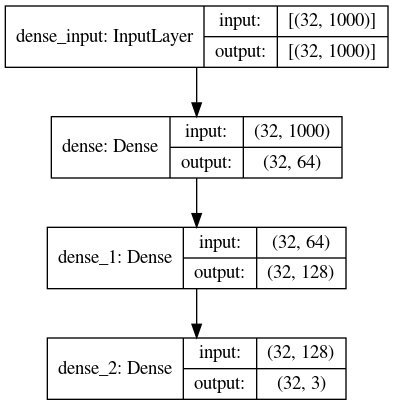

In [11]:
# Hyperparameters
num_lay1 = 64          # Number of filters in the first layer
num_hidden = num_lay1*2 # Number of units in the hidden layer
num_layout = 3          # Number of neurons in the output layer; each node represents a class of signal
num_epochs = 10

# Model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(num_lay1, activation='relu'),
    tf.keras.layers.Dense(num_hidden, activation='relu'),
    tf.keras.layers.Dense(num_layout, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.1), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

# Train the model
history = model.fit(x = X_train, y = y_train, epochs = num_epochs) 

# Plot a design of the model
plot_model(model, show_shapes=True)

We trained our neural network and now we want to check its performance.

188/188 [==============================] - 0s 924us/step - loss: 0.9081 - accuracy: 0.9993
Accuracy on test dataset: 0.9993333220481873
[[1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00]
 ...
 [0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 6.3972766e-24]
 [1.0000000e+00 0.0000000e+00 1.4909378e-32]]


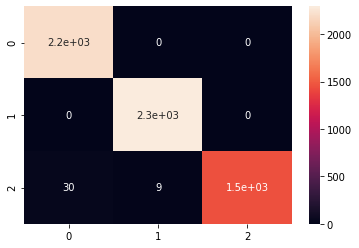

In [12]:
# Evaluate accuracy
test_loss, test_accuracy = model.evaluate(x = X_test, y = y_test)
print('Accuracy on test dataset:', test_accuracy)       

# Make predictions
y_pred = model.predict(X_test) 

# From each row take index with the biggest value
y_pred_labels = tf.argmax(y_pred, axis=1)
print(y_pred)

# Evaluating confusion matrix
CM = tf.math.confusion_matrix(labels = y_test, predictions = y_pred_labels, num_classes = 3)
sns.heatmap(CM, annot=True)
plt.show()

## Visualizing model performance
This plot will shows loss and accuracyfor our toy model. X-axis represents the epoch number.

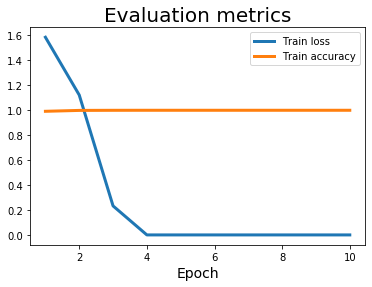

In [13]:
plt.plot(
    np.arange(1, num_epochs + 1), 
    history.history['loss'], 
    label='Train loss', lw=3
)

plt.plot(
    np.arange(1, num_epochs + 1), 
    history.history['accuracy'], 
    label='Train accuracy', lw=3
)

plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

# 2. *Signal + noise*

Now let us add some noise to classes 0 and 1. This noise will be smaller than in class 3 (let's start with 10%), because we want signals to be visible - in the next steps we should try different signal-to-noise ratios to verify when our method cannot be applied.

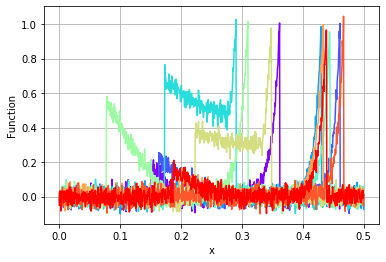

In [14]:
arr_signal1_n = []
color = iter(cm.rainbow(np.linspace(0, 1, 10)))
fig6 = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax6 = plt.subplot(gs[0])    
ax6.set_ylabel(r'Function')	
ax6.set_xlabel(r'x')
ax6.grid(True)
for i in range(10 * len(f)):
    noise = np.random.normal(0, 1.0, len(f))
# Normalise
    noise = noise/max(abs(noise))
    noise = 0.1*noise
    signal_n = noise + arr_signal1[i, 1:]
    arr_signal1_n.append(signal_n)
    if i%1000 == 0:
        c = next(color)
        ax6.plot(freq, signal_n, color=c, linestyle = '-')
arr_signal1_n = np.asarray(arr_signal1_n)
# First column is dedicated for the label
extra_col = np.zeros((arr_signal1_n.shape[0], 1))
extra_col.fill(0)
arr_signal1_n = np.hstack((extra_col, arr_signal1_n))

And let's do the same with line:

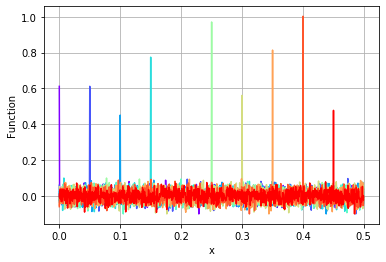

In [15]:
arr_signal2_n = []
color = iter(cm.rainbow(np.linspace(0, 1, 10)))
fig7 = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax7 = plt.subplot(gs[0])    
ax7.set_ylabel(r'Function')	
ax7.set_xlabel(r'x')
ax7.grid(True)
for i in range(10 * len(f)):
    noise = np.random.normal(0, 1.0, len(f))
# Normalise
    noise = noise/max(abs(noise))
    noise = 0.1*noise
    signal_n = noise + arr_signal2[i, 1:]
    arr_signal2_n.append(signal_n)
    if i%1000 == 0:
        c = next(color)
        ax7.plot(freq, signal_n, color=c, linestyle = '-')
arr_signal2_n = np.asarray(arr_signal2_n)
# First column is dedicated for the label
extra_col = np.zeros((arr_signal2_n.shape[0], 1))
extra_col.fill(1)
arr_signal2_n = np.hstack((extra_col, arr_signal2_n))

And now let us feed neural network with the noisy data:

(30000, 1001)
24000 1000
Epoch 1/10
750/750 [==============================] - 1s 1ms/step - loss: 36.2832 - accuracy: 0.9960
Epoch 2/10
750/750 [==============================] - 1s 1ms/step - loss: 2.9081 - accuracy: 0.9993
Epoch 3/10
750/750 [==============================] - 1s 1ms/step - loss: 0.8815 - accuracy: 0.9998
Epoch 4/10
750/750 [==============================] - 1s 1ms/step - loss: 1.6322 - accuracy: 0.9997
Epoch 5/10
750/750 [==============================] - 1s 1ms/step - loss: 1.2563 - accuracy: 0.9997
Epoch 6/10
750/750 [==============================] - 1s 2ms/step - loss: 7.2823 - accuracy: 0.9994
Epoch 7/10
750/750 [==============================] - 1s 2ms/step - loss: 7.3090 - accuracy: 0.9998
Epoch 8/10
750/750 [==============================] - 1s 1ms/step - loss: 10.3311 - accuracy: 0.9996
Epoch 9/10
750/750 [==============================] - 2s 2ms/step - loss: 5.3857 - accuracy: 0.9995
Epoch 10/10
188/188 [==============================] - 0s 836us/step - lo

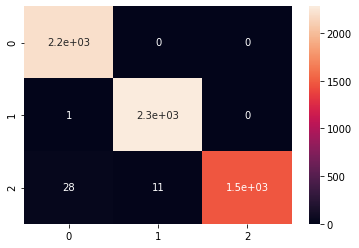

In [16]:
arr_in_n = np.concatenate((arr_signal1_n, arr_signal2_n, arr_signal3), axis=0)
print(arr_in_n.shape)

# Shuffle rows of the array with the data
random.shuffle(arr_in_n)

# The first column contains the target labels
p = int(0.8*arr_in_n.shape[0])
X_train_n = arr_in_n[:p, 1:]
y_train_n = arr_in_n[:p, 0]
X_test_n = arr_in_n[p:, 1:]
y_test_n = arr_in_n[p:, 0]
N_n = X_train_n.shape[0]
D_n = X_train_n.shape[1]
print(N_n,D_n)

# Train the model
history_n = model.fit(x = X_train_n, y = y_train_n, epochs = num_epochs) 

# Evaluate accuracy
test_loss_n, test_accuracy_n = model.evaluate(x = X_test_n, y = y_test_n)
print('Accuracy on test dataset without the noise:', test_accuracy)       
print('Accuracy on test dataset with the noise:', test_accuracy_n)       


# Make predictions
y_pred_n = model.predict(X_test_n) 

# From each row take index with the biggest value
y_pred_labels_n = tf.argmax(y_pred_n, axis=1)
print(y_pred_n)

# Evaluating confusion matrix
CM = tf.math.confusion_matrix(labels = y_test_n, predictions = y_pred_labels_n, num_classes = 3)
sns.heatmap(CM, annot=True)
plt.show()

We see that for 10% noise results are still comparable as in the case without the noise.

Now let us do the same with 90% noise.

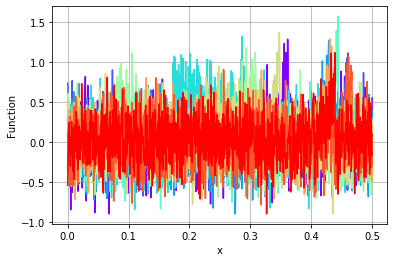

In [17]:
arr_signal1_n = []
color = iter(cm.rainbow(np.linspace(0, 1, 10)))
fig6 = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax6 = plt.subplot(gs[0])    
ax6.set_ylabel(r'Function')	
ax6.set_xlabel(r'x')
ax6.grid(True)
for i in range(10 * len(f)):
    noise = np.random.normal(0, 1.0, len(f))
# Normalise
    noise = noise/max(abs(noise))
    noise = 0.9*noise
    signal_n = noise + arr_signal1[i, 1:]
    arr_signal1_n.append(signal_n)
    if i%1000 == 0:
        c = next(color)
        ax6.plot(freq, signal_n, color=c, linestyle = '-')
arr_signal1_n = np.asarray(arr_signal1_n)
# First column is dedicated for the label
extra_col = np.zeros((arr_signal1_n.shape[0], 1))
extra_col.fill(0)
arr_signal1_n = np.hstack((extra_col, arr_signal1_n))

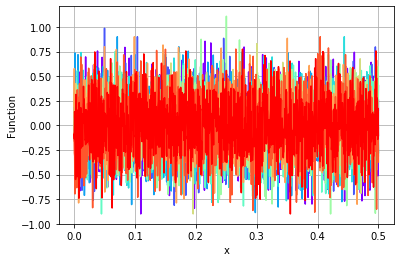

In [18]:
arr_signal2_n = []
color = iter(cm.rainbow(np.linspace(0, 1, 10)))
fig7 = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax7 = plt.subplot(gs[0])    
ax7.set_ylabel(r'Function')	
ax7.set_xlabel(r'x')
ax7.grid(True)
for i in range(10 * len(f)):
    noise = np.random.normal(0, 1.0, len(f))
# Normalise
    noise = noise/max(abs(noise))
    noise = 0.9*noise
    signal_n = noise + arr_signal2[i, 1:]
    arr_signal2_n.append(signal_n)
    if i%1000 == 0:
        c = next(color)
        ax7.plot(freq, signal_n, color=c, linestyle = '-')
arr_signal2_n = np.asarray(arr_signal2_n)
# First column is dedicated for the label
extra_col = np.zeros((arr_signal2_n.shape[0], 1))
extra_col.fill(1)
arr_signal2_n = np.hstack((extra_col, arr_signal2_n))

(30000, 1001)
24000 1000
Epoch 1/10
750/750 [==============================] - 1s 1ms/step - loss: 3750.7932 - accuracy: 0.9227
Epoch 2/10
750/750 [==============================] - 1s 1ms/step - loss: 34.4696 - accuracy: 0.9337
Epoch 3/10
750/750 [==============================] - 1s 1ms/step - loss: 14.1665 - accuracy: 0.9277
Epoch 4/10
750/750 [==============================] - 1s 1ms/step - loss: 6.9843 - accuracy: 0.9049
Epoch 5/10
750/750 [==============================] - 1s 1ms/step - loss: 2.8159 - accuracy: 0.8838
Epoch 6/10
750/750 [==============================] - 1s 1ms/step - loss: 1.8171 - accuracy: 0.8765
Epoch 7/10
750/750 [==============================] - 1s 1ms/step - loss: 0.9858 - accuracy: 0.8629
Epoch 8/10
750/750 [==============================] - 1s 1ms/step - loss: 0.5381 - accuracy: 0.8601
Epoch 9/10
750/750 [==============================] - 1s 1ms/step - loss: 0.4524 - accuracy: 0.8622
Epoch 10/10
188/188 [==============================] - 0s 875us/step -

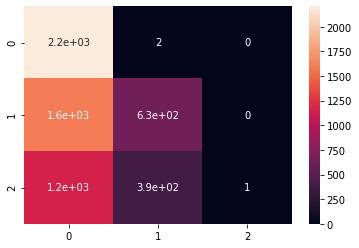

In [19]:
arr_in_n = np.concatenate((arr_signal1_n, arr_signal2_n, arr_signal3), axis=0)
print(arr_in_n.shape)

# Shuffle rows of the array with the data
random.shuffle(arr_in_n)

# The first column contains the target labels
p = int(0.8*arr_in_n.shape[0])
X_train_n = arr_in_n[:p, 1:]
y_train_n = arr_in_n[:p, 0]
X_test_n = arr_in_n[p:, 1:]
y_test_n = arr_in_n[p:, 0]
N_n = X_train_n.shape[0]
D_n = X_train_n.shape[1]
print(N_n,D_n)

# Train the model
history_n = model.fit(x = X_train_n, y = y_train_n, epochs = num_epochs) 

# Evaluate accuracy
test_loss_n, test_accuracy_n = model.evaluate(x = X_test_n, y = y_test_n)
print('Accuracy on test dataset without the noise:', test_accuracy)       
print('Accuracy on test dataset with the noise:', test_accuracy_n)       


# Make predictions
y_pred_n = model.predict(X_test_n) 

# From each row take index with the biggest value
y_pred_labels_n = tf.argmax(y_pred_n, axis=1)
print(y_pred_n)

# Evaluating confusion matrix
CM = tf.math.confusion_matrix(labels = y_test_n, predictions = y_pred_labels_n, num_classes = 3)
sns.heatmap(CM, annot=True)
plt.show()

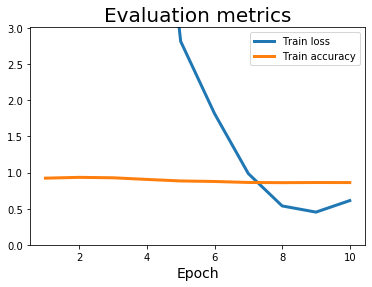

In [20]:
plt.plot(
    np.arange(1, num_epochs + 1), 
    history_n.history['loss'], 
    label='Train loss', lw=3
)

plt.plot(
    np.arange(1, num_epochs + 1), 
    history_n.history['accuracy'], 
    label='Train accuracy', lw=3
)
plt.ylim(0,3.01)

plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

Not great. First thing: let us increase number of epochs:

Epoch 1/100
750/750 [==============================] - 1s 1ms/step - loss: 1.3436 - accuracy: 0.8531
Epoch 2/100
750/750 [==============================] - 1s 1ms/step - loss: 2.5506 - accuracy: 0.8368
Epoch 3/100
750/750 [==============================] - 1s 1ms/step - loss: 3.5629 - accuracy: 0.8102
Epoch 4/100
750/750 [==============================] - 1s 1ms/step - loss: 3.2152 - accuracy: 0.8039
Epoch 5/100
750/750 [==============================] - 1s 1ms/step - loss: 0.6181 - accuracy: 0.7981
Epoch 6/100
750/750 [==============================] - 1s 1ms/step - loss: 1.4529 - accuracy: 0.7950
Epoch 7/100
750/750 [==============================] - 1s 1ms/step - loss: 0.6803 - accuracy: 0.7907
Epoch 8/100
750/750 [==============================] - 1s 1ms/step - loss: 0.6268 - accuracy: 0.7922
Epoch 9/100
750/750 [==============================] - 1s 1ms/step - loss: 0.9102 - accuracy: 0.7910
Epoch 10/100
750/750 [==============================] - 1s 1ms/step - loss: 0.5826 - accura

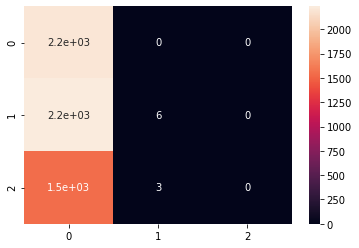

In [21]:
num_epochs = 100
# Train the model
history_n = model.fit(x = X_train_n, y = y_train_n, epochs = num_epochs) 

# Evaluate accuracy
test_loss_n, test_accuracy_n = model.evaluate(x = X_test_n, y = y_test_n)
print('Accuracy on test dataset without the noise:', test_accuracy)       
print('Accuracy on test dataset with the noise:', test_accuracy_n)       


# Make predictions
y_pred_n = model.predict(X_test_n) 

# From each row take index with the biggest value
y_pred_labels_n = tf.argmax(y_pred_n, axis=1)
print(y_pred_n)

# Evaluating confusion matrix
CM = tf.math.confusion_matrix(labels = y_test_n, predictions = y_pred_labels_n, num_classes = 3)
sns.heatmap(CM, annot=True)
plt.show()

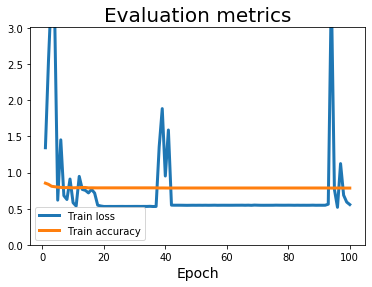

In [22]:
plt.plot(
    np.arange(1, num_epochs + 1), 
    history_n.history['loss'], 
    label='Train loss', lw=3
)

plt.plot(
    np.arange(1, num_epochs + 1), 
    history_n.history['accuracy'], 
    label='Train accuracy', lw=3
)
plt.ylim(0,3.01)

plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

Stil no improvement. We should try more advanced architecture of the model.

## Convolutional neural network

Architecture copied from [here](https://towardsdatascience.com/hands-on-climate-time-series-classification-with-deep-learning-using-python-6d5de81004c9). Note that more complex architecture results with (much!) longer execution time.

Epoch 1/10
4800/4800 [==============================] - 86s 18ms/step - loss: 0.5674 - sparse_categorical_accuracy: 0.7838
Epoch 2/10
4800/4800 [==============================] - 81s 17ms/step - loss: 0.5619 - sparse_categorical_accuracy: 0.7841
Epoch 3/10
4800/4800 [==============================] - 80s 17ms/step - loss: 0.5598 - sparse_categorical_accuracy: 0.7841
Epoch 4/10
4800/4800 [==============================] - 79s 16ms/step - loss: 0.5570 - sparse_categorical_accuracy: 0.7841
Epoch 5/10
4800/4800 [==============================] - 96s 20ms/step - loss: 0.5565 - sparse_categorical_accuracy: 0.7841
Epoch 6/10
4800/4800 [==============================] - 93s 19ms/step - loss: 0.5544 - sparse_categorical_accuracy: 0.7841
Epoch 7/10
4800/4800 [==============================] - 91s 19ms/step - loss: 0.5554 - sparse_categorical_accuracy: 0.7841
Epoch 8/10
4800/4800 [==============================] - 89s 19ms/step - loss: 0.5537 - sparse_categorical_accuracy: 0.7842
Epoch 9/10
4800/

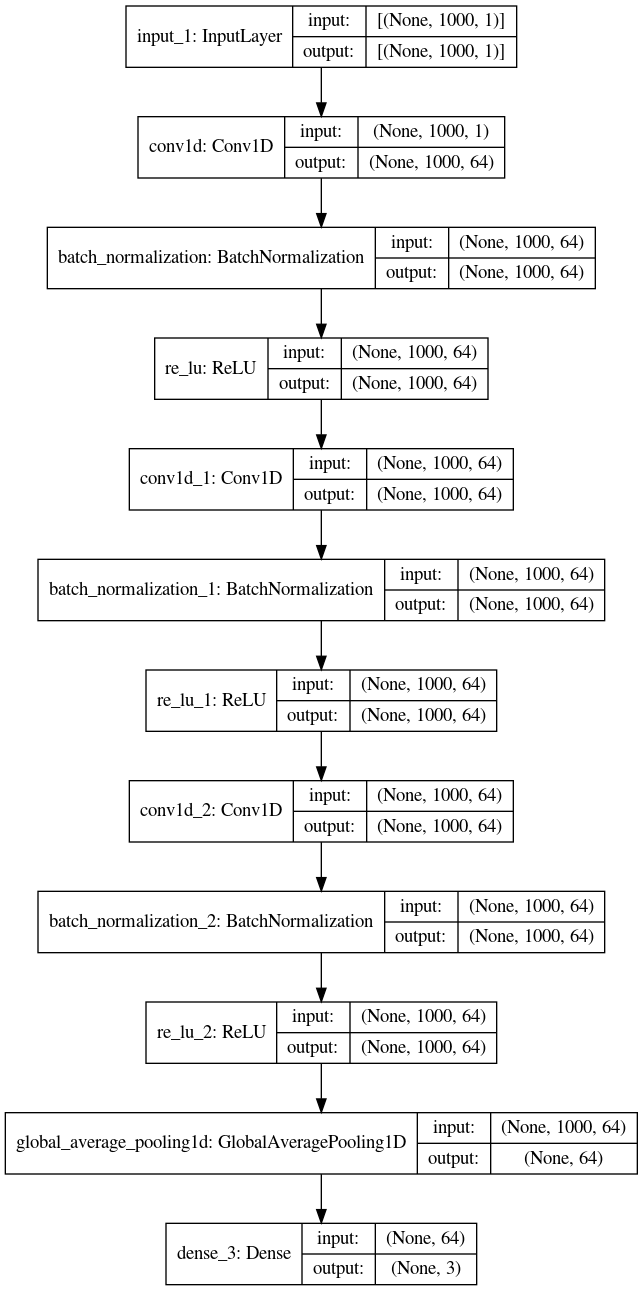

In [23]:
from tensorflow import keras
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(3, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

x_train = X_train_n.reshape((X_train_n.shape[0], X_train_n.shape[1], 1))
model2 = make_model(input_shape=x_train.shape[1:])

epochs = 10
batch_size = 5

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="loss", patience=50, verbose=1),
]
model2.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model2.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1,
)
# Plot a design of the model
plot_model(model2, show_shapes=True)

188/188 [==============================] - 5s 24ms/step - loss: 1.4544 - sparse_categorical_accuracy: 0.3682
Accuracy on test dataset: 0.36816665530204773
[[0.6119101  0.3632022  0.0248877 ]
 [0.5912686  0.3873502  0.0213812 ]
 [0.8870901  0.1093942  0.00351559]
 ...
 [0.59253865 0.37547773 0.0319836 ]
 [0.82888633 0.164451   0.00666268]
 [0.5977055  0.373472   0.02882255]]


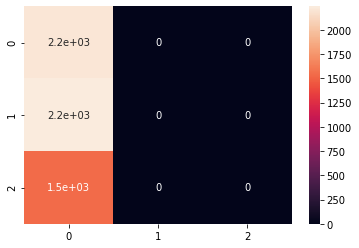

In [24]:
# Evaluate accuracy
test_loss, test_accuracy = model2.evaluate(x = X_test_n, y = y_test_n)
print('Accuracy on test dataset:', test_accuracy)       

# Make predictions
y_pred = model2.predict(X_test_n) 

# From each row take index with the biggest value
y_pred_labels = tf.argmax(y_pred, axis=1)
print(y_pred)

# Evaluating confusion matrix
CM = tf.math.confusion_matrix(labels = y_test_n, predictions = y_pred_labels, num_classes = 3)
sns.heatmap(CM, annot=True)
plt.show()

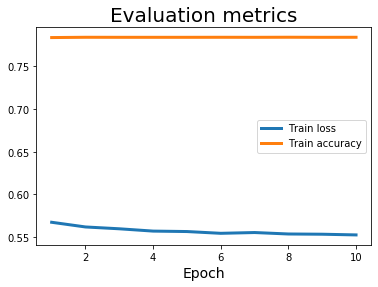

In [27]:
plt.plot(
    np.arange(1, epochs + 1), 
    history.history['loss'], 
    label='Train loss', lw=3
)

plt.plot(
    np.arange(1, epochs + 1), 
    history.history['sparse_categorical_accuracy'], 
    label='Train accuracy', lw=3
)
#plt.ylim(0,3.01)

plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

Still not great but I used only 10 epochs. This should be run on some more powerful machine.